In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [2]:
batch_size = 128

train_datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'fingers/train/',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=batch_size,
    classes=['zero', 'one', 'two', 'three', 'four', 'five'],
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    'fingers/test/',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=batch_size,
    classes=['zero', 'one', 'two', 'three', 'four', 'five'],
    class_mode='categorical'
)

In [3]:
pathTrain = "data/train/*"
pathTest = "data/test/*"
NUMBER_OF_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 5

indice_to_label = {0:"0", 1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}
label_to_indice = {v:k for k,v in indice_to_label.items()}

In [4]:
import cv2
def process_image(img,kernel):
    img = cv2.resize(img, (128, 128))
    img = cv2.GaussianBlur(img,(5,5),0)
    _,img = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
    
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    
    
    img = img/255
    return img

def img_to_sample(img, kernel = None):
    img = img.astype(np.uint8)
    img = np.reshape(img, (128, 128))
    
    img = process_image(img, kernel)
    
    img = np.reshape(img, (128, 128, 1))
    return img

In [5]:
train_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTrain)]
test_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTest)]

In [6]:
X_Train = [t[1] for t in train_set]
X_Train = X_Train + X_Train[0:6000]
Y_Train = [label_to_indice[t[0]] for t in train_set]
Y_Train = Y_Train + Y_Train[0:6000]

X_Test = [t[1] for t in test_set]
X_Test = X_Test
Y_Test = [label_to_indice[t[0]] for t in test_set]
Y_Test = Y_Test

X_Train = np.array(X_Train)
Y_Train = to_categorical(Y_Train, num_classes = NUMBER_OF_CLASSES)
X_Test = np.array(X_Test)
Y_Test = to_categorical(Y_Test, num_classes = NUMBER_OF_CLASSES)

In [7]:
print(X_Train.shape)
print(Y_Train.shape)

print(X_Test.shape)
print(Y_Test.shape)

(13904, 128, 128, 1)
(13904, 6)
(3600, 128, 128, 1)
(3600, 6)


In [8]:
aug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range = 0.1,
    horizontal_flip=False,
    fill_mode="nearest")

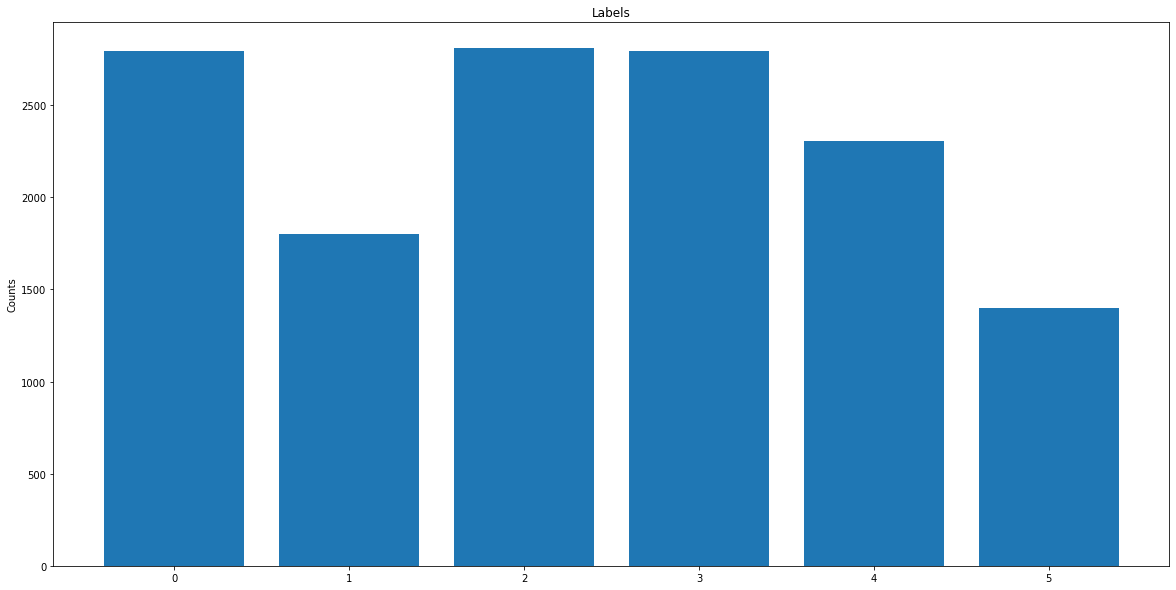

In [9]:
counts = Counter([x.argmax() for x in Y_Train])
plt.subplots(figsize = (20,10))
values = [k for k in counts.values()]
labels = [k for k in counts.keys()]
plt.bar(labels, values, align='center')
plt.ylabel('Counts')
plt.title('Labels')

plt.show()

In [10]:
def HandModel(input_shape):
    
    X_input = Input(input_shape, name = "input_layer")
    
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu')(X_input)
    X = BatchNormalization()(X)
    
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(64, (5, 5), strides = (2, 2), padding="same", activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.2)(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(128, (5, 5), strides = (2, 2), padding="same", activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)

    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.4)(X)
    
    X = Dense(NUMBER_OF_CLASSES, activation='softmax', name='output_layer')(X)

    model = Model(inputs = X_input, outputs = X, name='HandModel')

    return model

In [11]:
sgd = optimizers.SGD(lr=0.01, nesterov=True)

In [30]:
model = HandModel(X_Train.shape[1:])
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ["accuracy"])

with open('handmodel_fingers_architecture.json', 'w') as f:
    f.write(model.to_json())
    
filename = "handmodel_fingers_weights.hdf5"
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

In [22]:
from tensorflow import keras
model = keras.models.load_model("handmodel_fingers_model.h5")
# history = model.fit_generator(generator = aug.flow(X_Train, Y_Train, batch_size=BATCH_SIZE), steps_per_epoch= X_Train.shape[0] // BATCH_SIZE, validation_data=aug.flow(X_Test, Y_Test, batch_size=BATCH_SIZE), validation_steps = X_Test.shape[0] // BATCH_SIZE, epochs = 2, callbacks=callbacks_list)

In [23]:
ev = model.evaluate(X_Test, Y_Test)

print("Loss : ",ev[0])
print("Accuracy : {} %".format(ev[1]*100))

print(ev)

113/113 [==============================] - 46s 411ms/step - loss: 0.0729 - accuracy: 0.9936
Loss :  0.07286649942398071
Accuracy : 99.36110973358154 %
[0.07286649942398071, 0.9936110973358154]


In [24]:
#model.save('handmodel_fingers_model.h5')

In [25]:
preds = model.predict(X_Test)
preds = (preds > 0.5).astype(int)

In [26]:
y_preds = [l.index(1) if 1 in l else 0 for l in preds.tolist()]
y_true = [l.index(1) for l in Y_Test.tolist()]

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_preds)

print(classification_report(y_true, y_preds))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       600
           1       1.00      0.99      1.00       600
           2       0.99      0.99      0.99       600
           3       0.98      0.99      0.99       600
           4       1.00      0.98      0.99       600
           5       1.00      1.00      1.00       600

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600

